#### GOAL:
Use LiDAR Roof data to develop distributions of roofsize by sector that can be sampled as representative for all of India.

#### PROBLEM:
We have over 4 million polygons, which *may* be associated with a single roof, however multiple polygons may also symbolize multiple planes of a single roof

#### IMPLEMENTATION:
    1. Take sum of all rooftop area.
    2. Sample polygons equal to number of customers. 
    3. Multiply sampled polygons by scaler to equal total rooftop area. So that 1 polygon becomes representative of an entire roof.
    4. Split matrix into three clusters, based on multiples of standard deviation as a threashold.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math



In [2]:
!ls

Financing of Solar Rooftop   Subscriber Count
Policy Overview _ Tariffs    exploring_consumption.ipynb
Polygon Area                 exploring_roofs.ipynb
Prospective Feeder List.xlsx


In [3]:
polygons_dict = pd.read_excel(os.path.join('Polygon Area','NREL All Polygon List.xlsx'),
                           sheet_name=None,
                           usecols='F,G')
polygons = pd.concat([df for df in polygons_dict.values()], axis='rows', ignore_index=True)

In [4]:
polygons *= 10.764 #sqm to sqft
polygons.columns = ['total_sqft','developable_sqft']
polygons = polygons.loc[polygons['developable_sqft'] > 0]

In [5]:
polygons.describe()

,total_sqft,developable_sqft
count,651067.000000,651067.000000
mean,1184.513477,308.198612
std,1942.038836,888.850486
min,108.070560,64.584000
25%,510.859440,86.112000
50%,801.810360,129.168000
75%,1211.488200,258.336000
max,173691.456120,109211.544000


In [6]:
# 1) Take sum of all rooftop area
total_area = polygons['developable_sqft'].sum()

In [16]:
#2) Sample polygons equal to number of customers 

n_res = 4310647
n_com = 674743
n_ind = 7610
n_customers = n_res + n_com + n_ind

roofs = polygons.sample(n_customers, replace=True)
roofs = roofs['developable_sqft'].copy()


res mu:149.33, std:91.45
com mu:1155.37, std:1075.19
ind mu:15169.55, std:10717.58


Text(0.5, 1.0, 'CDF of Developable Sqft by Sector')

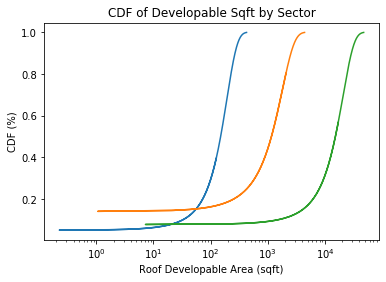

In [24]:
#4) Sort roofs and break into thirds equal to number of customers in each sector
roofs.sort_values(inplace=True, ascending=True)
res = roofs[:n_res]
com = roofs[n_res:(n_res+n_com)]
ind = roofs[(n_res+n_com):]

fig, ax = plt.subplots()

for sector, df in zip(['res', 'com', 'ind'], [res, com, ind]):
    mu = df.mean()
    sigma = df.std()
    print(f"{sector} mu:{round(mu,2)}, std:{round(sigma,2)}")
    
    x = abs(np.linspace(mu - 3*sigma, mu + 3*sigma, 300))
    y = stats.norm.cdf(x, mu, sigma)
    ax.plot(x, y, label=sector)
    
ax.set_xscale('log')
ax.set_xlabel('Roof Developable Area (sqft)')
ax.set_ylabel('CDF (%)')
ax.set_title('CDF of Developable Sqft by Sector')

In [ ]:
mask = (roofs['sqm'] < (mu + 1*std))
df = roofs.loc[mask]
df.hist(bins=100)

In [ ]:
# divide roofs into 